In [1]:
#pip install azure-storage-blob pandas numpy pmdarima tensorflow


In [1]:
from azure.storage.blob import BlobServiceClient
import pandas as pd
from io import StringIO

# Connection details
account_name = "mainprojectwis"
account_key = "S4laxfCtH7dA87w7OGPHQVBfF39zGGeXGBDH65aYHGDJLXs4y+1UWHjLbmQoH38oehZ+1KukGIOy+AStlQdbKA=="
container_name = "mymaincontainer"
blob_name = "transformed-data/hourly_weather_data.csv"  # Adjusted file path

# Construct connection string
connection_string = f"DefaultEndpointsProtocol=https;AccountName={account_name};AccountKey={account_key};EndpointSuffix=core.windows.net"

# Connect to Blob Service Client
blob_service_client = BlobServiceClient.from_connection_string(connection_string)

# Access the specific blob
blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)

# Download blob content
print("Downloading blob content...")
blob_data = blob_client.download_blob().content_as_text()

# Convert CSV data into a DataFrame
df = pd.read_csv(StringIO(blob_data))
df = df.drop(columns=['year', 'month'])
# Display the DataFrame
print("Data preview:")
print(df.head())

# Parse 'timestamp' as datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Set 'timestamp' as the index
df.set_index('timestamp', inplace=True)

# Verify the index type
print("Index type:", type(df.index))

Data preview:
   temperature  dew_point_temperature  station_level_pressure  \
0          7.2                    6.7                  1002.5   
1          6.7                    6.7                  1002.9   
2          6.1                    6.1                  1002.2   
3          7.2                    7.2                  1001.5   
4          6.1                    6.1                   999.8   

   sea_level_pressure  wind_direction  wind_speed  precipitation  \
0              1003.3           200.0         9.8            0.3   
1              1003.7           200.0         5.7            0.3   
2              1003.0           200.0         4.1            0.0   
3              1002.3           230.0         3.6            0.0   
4              1000.6           190.0         2.6            1.3   

   relative_humidity  visibility  altimeter            timestamp  hour  \
0               97.0         0.8     1003.4  1990-01-01 00:00:00     0   
1              100.0         0.8     1

In [2]:
# Resample the data to daily averages
df_daily = df.resample('D').mean()

# Fill missing values
df_daily = df_daily.fillna(method='ffill')  # Forward fill for continuous data

# Verify the cleaned data
print("Cleaned and Resampled Data:")
print(df_daily.head())

Cleaned and Resampled Data:
            temperature  dew_point_temperature  station_level_pressure  \
timestamp                                                                
1990-01-01     5.516667               0.420833             1002.400000   
1990-01-02     1.570833              -7.679167             1023.083333   
1990-01-03     2.150000              -4.233333             1025.429167   
1990-01-04     2.704167              -0.483333             1019.200000   
1990-01-05     6.870833               0.095833             1015.662500   

            sea_level_pressure  wind_direction  wind_speed  precipitation  \
timestamp                                                                   
1990-01-01         1003.187500      259.166667    7.387500       0.495833   
1990-01-02         1023.879167      289.583333    6.950000       0.000000   
1990-01-03         1026.229167      235.833333    3.820833       0.000000   
1990-01-04         1019.995833      217.500000    3.679167       0.0

In [3]:
from statsmodels.tsa.stattools import adfuller

subset = df_daily['temperature']['2002':'2022']
# Perform ADF test for stationarity
adf_test = adfuller(subset.dropna())  # Ensure no NaN values
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])

# Interpret the results
if adf_test[1] > 0.05:
    print("Time series is non-stationary. Differencing may be required.")
else:
    print("Time series is stationary.")


ADF Statistic: -5.995232021719038
p-value: 1.7078661073770545e-07
Time series is stationary.


In [5]:
from pmdarima import auto_arima

# Subset data to the last 4 years
subset = df_daily['temperature']['2018':'2022']

# Run auto_arima on the subset
sarima_model = auto_arima(subset,  # Use the subset
                          seasonal=True, 
                          m=24,  # Daily periodicity
                          max_p=12,  
                          max_d=1, 
                          max_q=3,  
                          max_P=2, 
                          max_D=1, 
                          max_Q=2, 
                          stepwise=True,  # Use stepwise search for efficiency
                          suppress_warnings=True, 
                          trace=True)

print("Best SARIMA parameters:", sarima_model.order)
print("Best seasonal parameters:", sarima_model.seasonal_order)


Performing stepwise search to minimize aic



KeyboardInterrupt



                               SARIMAX Results                                
Dep. Variable:            temperature   No. Observations:                12394
Model:               SARIMAX(4, 0, 1)   Log Likelihood              -29677.779
Date:                Sun, 08 Dec 2024   AIC                          59367.558
Time:                        00:15:23   BIC                          59412.105
Sample:                    01-01-1990   HQIC                         59382.478
                         - 12-07-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6614      0.013    127.509      0.000       1.636       1.687
ar.L2         -0.8984      0.018    -50.781      0.000      -0.933      -0.864
ar.L3          0.2958      0.016     18.882      0.0

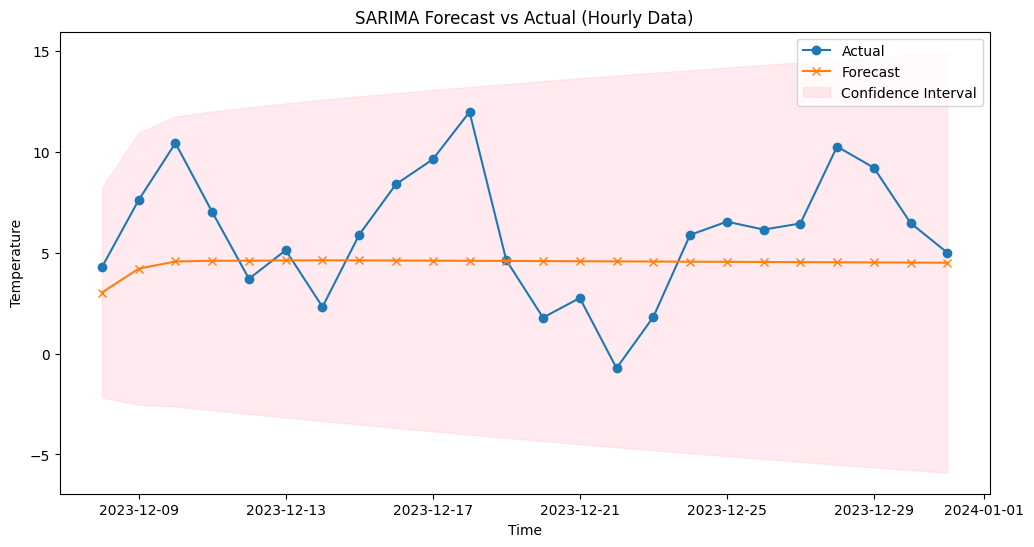

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pickle

# ---------------- Step 1: Split Data ---------------- #
# Training and testing split (last 3 days = 72 hours)
train = df_daily['temperature'][:-24]  # Replace 'temperature' with your column name
test = df_daily['temperature'][-24:]

# ---------------- Step 2: Train SARIMA ---------------- #
# Train the SARIMA model
model = SARIMAX(train, 
                order=(4, 0, 1), 
                seasonal_order=(0, 0, 0, 24),  # Monthly seasonality (72-hour cycles)
                enforce_stationarity=False, 
                enforce_invertibility=False)

sarima_fitted = model.fit(disp=False)

# Print the model summary
print(sarima_fitted.summary())

# ---------------- Step 3: Forecast ---------------- #
# Forecast for the next 72 hours (3 days)
forecast = sarima_fitted.get_forecast(steps=24)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# ---------------- Step 4: Evaluate ---------------- #
# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(test, forecast_mean))
mae = mean_absolute_error(test, forecast_mean)

print(f"SARIMA RMSE: {rmse}")
print(f"SARIMA MAE: {mae}")

# ---------------- Step 5: Visualize ---------------- #
# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', marker='o')
plt.plot(test.index, forecast_mean, label='Forecast', marker='x')
plt.fill_between(test.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.legend()
plt.title("SARIMA Forecast vs Actual (Hourly Data)")
plt.xlabel("Time")
plt.ylabel("Temperature")
plt.show()

# ---------------- Step 6: Save Model ---------------- #
# Save the SARIMA model
with open('sarima_model.pkl', 'wb') as f:
    pickle.dump(sarima_fitted, f)



findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: Font family 'Poppins' not found.
findfont: F

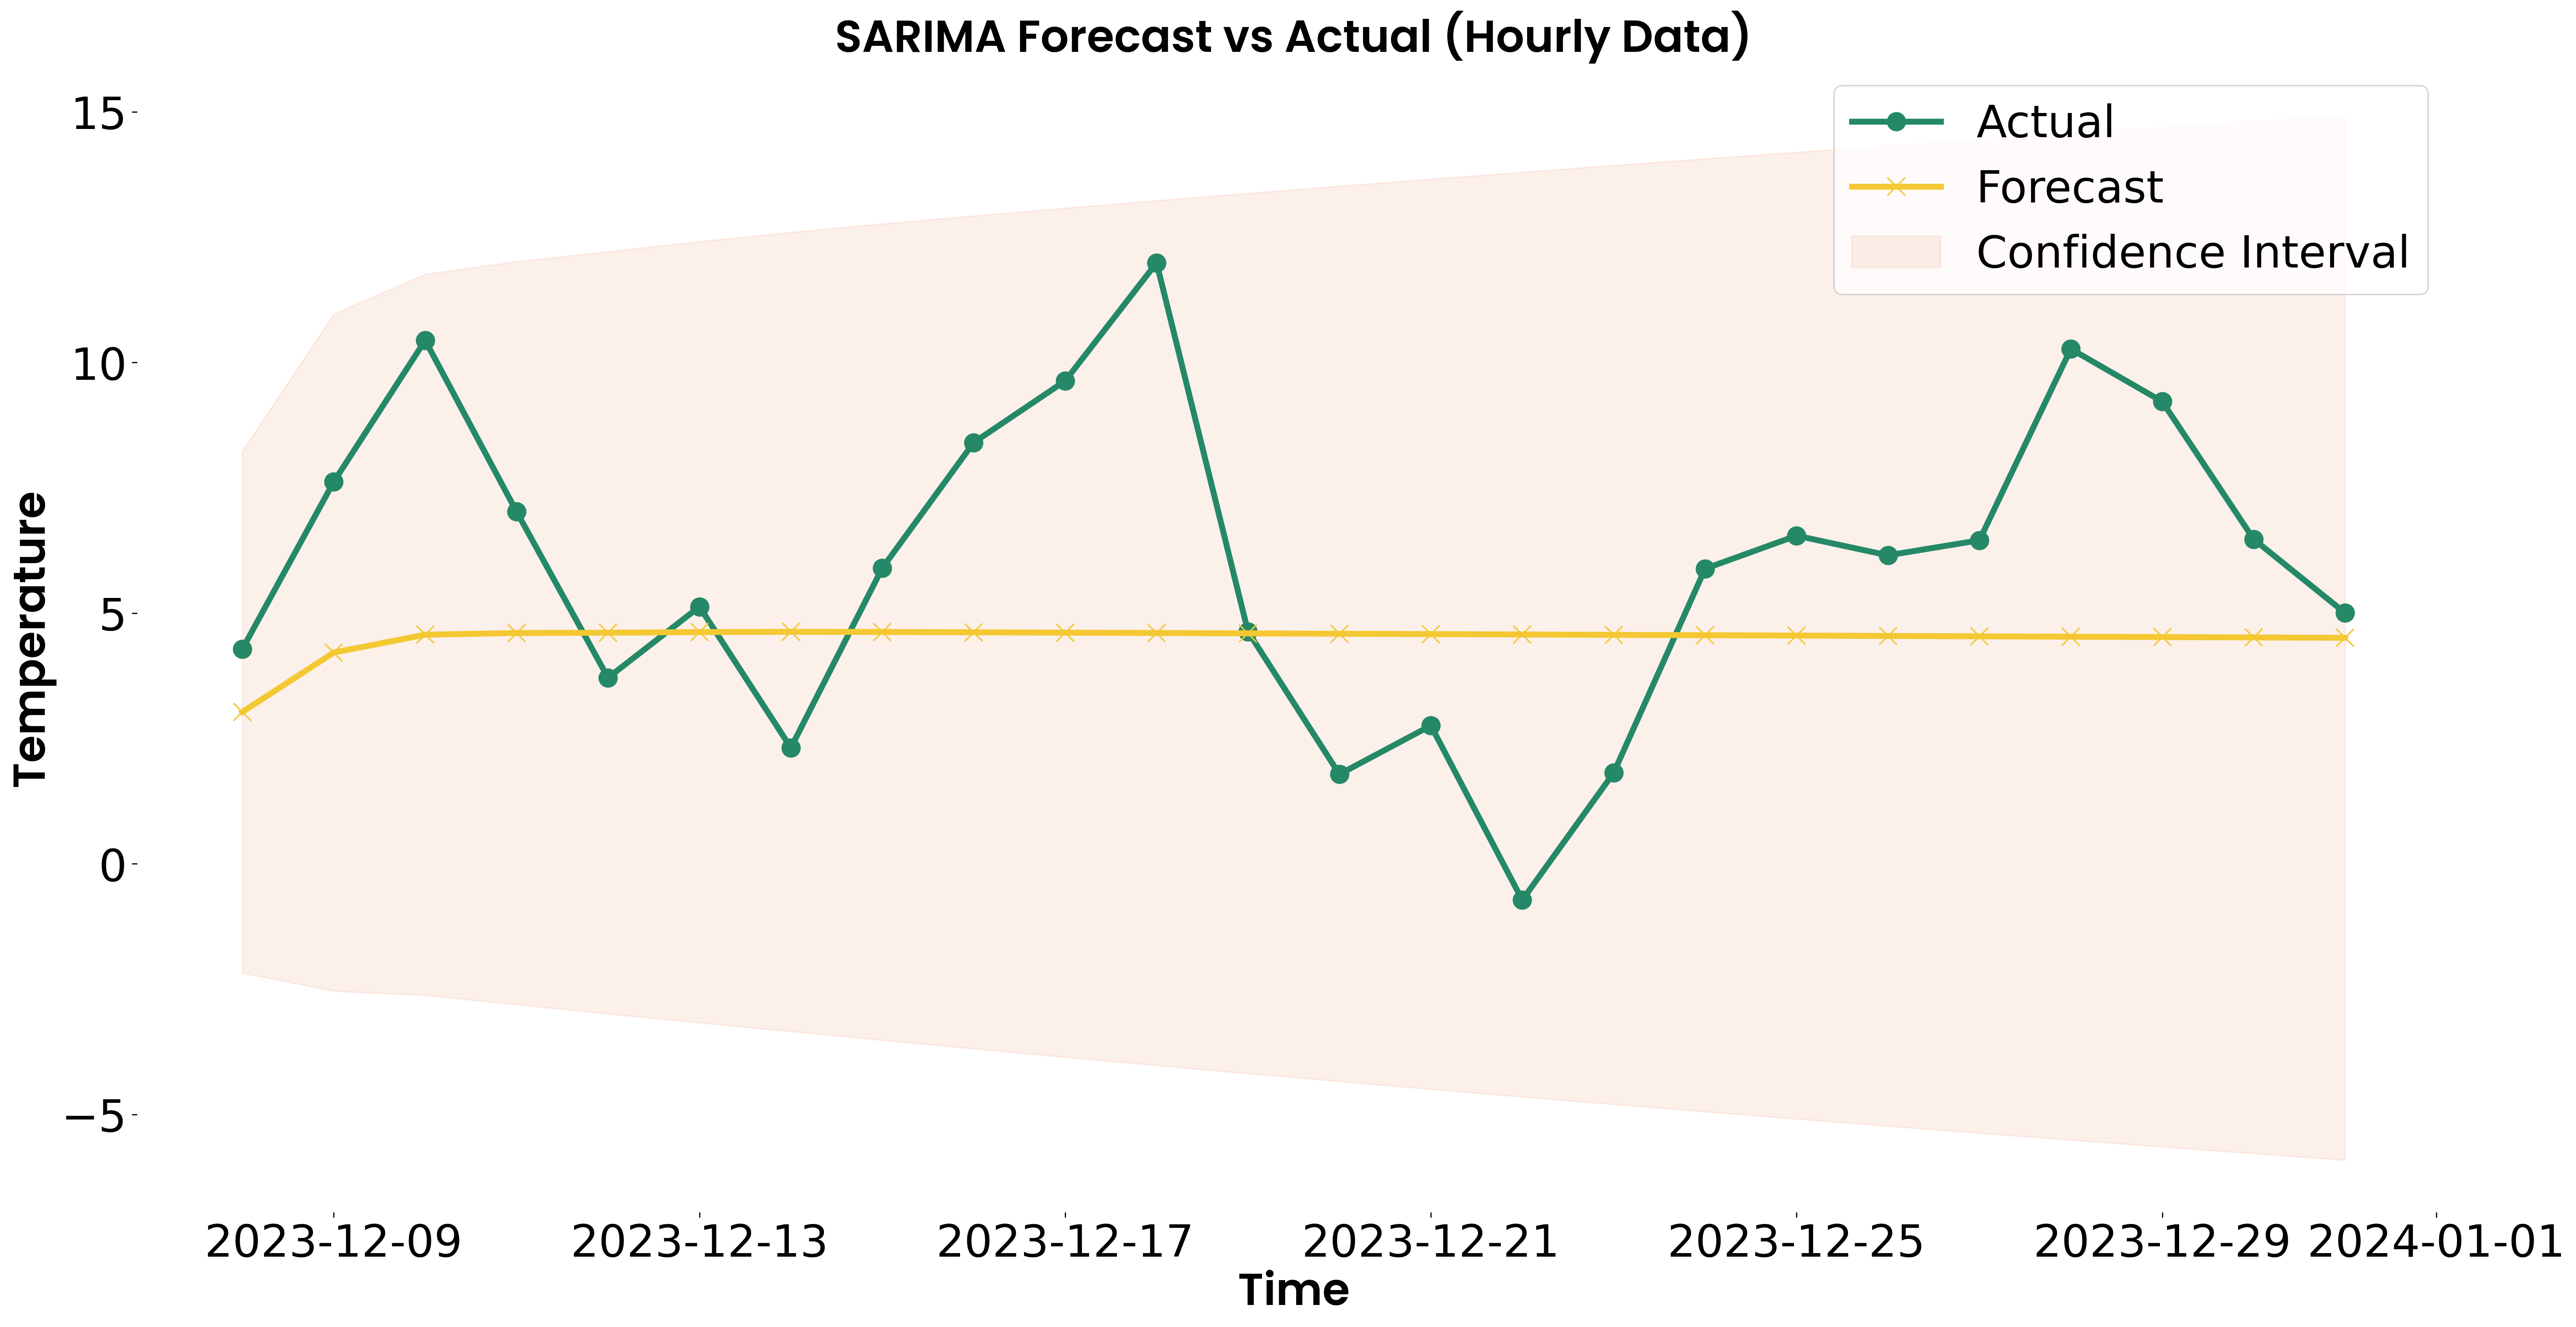

In [28]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams

# Specify the path to your Poppins font file (adjust the path if needed)
poppins_path = './Poppins-SemiBold.ttf'  # Replace with your actual font file path

# Load the font
poppins_font = fm.FontProperties(fname=poppins_path)

# Update rcParams to use the custom font and set font size
rcParams['font.family'] = poppins_font.get_name()
rcParams['font.size'] = 30  # Set default text size
rcParams['font.weight'] = 'medium'

# Plot actual vs forecasted values with your color codes
plt.figure(figsize=(28, 14), dpi=300)

# Plot actual values with bold line and larger data points
plt.plot(test.index, test, label='Actual', marker='o', color='#258967', linewidth=4, markersize=12)  # Bold line and larger markers

# Plot forecasted values with bold line and larger data points
plt.plot(test.index, forecast_mean, label='Forecast', marker='x', color='#f4c833', linewidth=4, markersize=12)  # Bold line and larger markers

# Fill the confidence interval with your requested color
plt.fill_between(test.index, 
                 forecast_conf_int.iloc[:, 0], 
                 forecast_conf_int.iloc[:, 1], 
                 color='#eb6f40', alpha=0.1, label='Confidence Interval')  # Confidence Interval color

# Remove plot borders (spines)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Add legend
plt.legend()

# Add title and labels
plt.title("SARIMA Forecast vs Actual (Hourly Data)", fontproperties=poppins_font)
plt.xlabel("Time", fontproperties=poppins_font)
plt.ylabel("Temperature", fontproperties=poppins_font)

# Save the plot as a high-quality PNG image
plt.savefig('sarima_forecast_vs_actual_updated_no_border_bold.png', format='png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


In [14]:
if os.path.exists(poppins_path):
    print("Font file found!")
else:
    print("Font file not found!")

Font file found!


In [7]:
import matplotlib.font_manager as fm
print([f.name for f in fm.fontManager.ttflist])


['cmex10', 'STIXNonUnicode', 'STIXGeneral', 'STIXSizeOneSym', 'STIXSizeTwoSym', 'STIXSizeTwoSym', 'STIXNonUnicode', 'DejaVu Serif', 'STIXGeneral', 'STIXGeneral', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans Mono', 'DejaVu Sans Display', 'STIXSizeFourSym', 'STIXSizeFourSym', 'DejaVu Sans', 'DejaVu Sans Mono', 'DejaVu Sans', 'cmmi10', 'cmr10', 'STIXSizeFiveSym', 'STIXNonUnicode', 'DejaVu Sans', 'cmss10', 'cmtt10', 'STIXNonUnicode', 'STIXSizeOneSym', 'STIXSizeThreeSym', 'STIXSizeThreeSym', 'DejaVu Sans Mono', 'DejaVu Serif Display', 'cmb10', 'DejaVu Sans Mono', 'DejaVu Serif', 'cmsy10', 'STIXGeneral', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Math TeX Gyre', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans Mono', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Sans Mono', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif']
